In [1]:
import h5py
import pylab as pl
import numpy as np
import matplotlib.colors as mpc
import networkx
import ipyvolume as ipv
import progressbar

In [2]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)

In [3]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

def get_main_branch_and_progNumb(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    numb = [[node], ]
    i = 0
    while True:
        successors = list(subtree.successors(node))
        if len(successors) == 0:
            break
        node = successors[0] # select only the first succesor (main branch)
        mpb.append(node)
        numb.append(successors)
        
    return mpb, numb


def set_view(figure, framenr, fraction):
    ipv.view(fraction*360, 0.)
    
def set_angles(fig, i, fraction):
    fig.angley = fraction*np.pi*2
    
    
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [4]:
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [5]:
def plotPhaseSpace(fofID, centralID):
    zer = np.array([])
    
    uniqueID = int(127*1e6+fofID)
    try:
        stree = networkx.dfs_tree(trees, str(uniqueID))
    except KeyError:
        return zer, zer, zer
    mtree, numbs = get_main_branch_and_progNumb(stree, str(uniqueID))
    
    uniqueC = int(127*1e6+centralID)
    try:
        streeC = networkx.dfs_tree(trees, str(uniqueC))
    except KeyError:
        return zer, zer, zer
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueC))
    
    # find all the particleIDs that once belong to the subgroup
    # Idlist, vallist, valcen = [], [], []
    Idlist, vallist = [], []
    
    for mm, mmC in zip(mtree[1:], mtreeC[1:]): # ignore the first one
        snap, idd = split_unique_id(int(mm))
        snapC, iddC = split_unique_id(int(mmC))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        pgal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        if snapC==snap:
            pcen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapC)][iddC]
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            Idlist.extend(list(tempIds))
            # calcule the value for color coding the graph
            val = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
            #val = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][tempOff[0]:tempOff[1]]
            #IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][tempOff[0]:tempOff[1]]
            #Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][tempOff[0]:tempOff[1]]
            #Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
            #ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][tempOff[0]:tempOff[1]]
            #val = tempFromMass(Mass, Abund, IE, ne1)
            # if val is one for each particles just append, otherwise do the next
            vallist.extend([val]*tempIds.size)
            # or
            #vallist.extend(list(val))

    Idlist, vallist = np.array(Idlist), np.array(vallist)
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    vallist = vallist[Idunique]

    
    # the total list of particles that once belong to a give subgroup, lest see where are today.
    TdayOff = sim['SnapNumber_127/SubGroups/PartType0/Offsets'][fofID].astype('int')
    TdayCoord = sim['SnapNumber_127/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]

    TdayTotalIDs = sim['SnapNumber_127/PartType0/ParticleIDs'][()]
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    #remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_127/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    LostCoord = sim['SnapNumber_127/PartType0/Coordinates'][IndexT_]

    # ... and the redshift
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    vallist_, Idlist_ = vallist[iidex_], Idlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    valorder = np.zeros(IndexT_.size)
    valorder[is1] = vallist_[is2]
    
    #now lets cut at  a certain distance
    distance = 600 # distance in ckpc

    posGal = sim['SnapNumber_127/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_127/SubGroups/SubGroupPos'][centralID]

    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut]
    valorder_near = valorder[icut]
    #IndexT_near = IndexT_
    #valorder_near = valorder
    
    NearCoord = sim['SnapNumber_127/PartType0/Coordinates'][IndexT_near]
    NearVel = sim['SnapNumber_127/PartType0/Velocities'][IndexT_near]
    
    # ok, lest see velocity and stuff
    velSat = sim['SnapNumber_128/SubGroups/SubGroupVel'][fofID]
    
    xo, yo, zo = NearCoord[:,0], NearCoord[:,1], NearCoord[:,2]
    xoC, yoC, zoC = xo - posGal[0], yo - posGal[1], zo - posGal[2]
    
    vxo, vyo, vzo = NearVel[:,0], NearVel[:,1], NearVel[:,2]
    vxoC, vyoC, vzoC = vxo - velSat[0], vyo - velSat[1], vzo - velSat[2]

    #cenPx, cenPy, cenPz = galH[:,0] - posCen[0], galH[:,1] - posCen[1], galH[:,2] - posCen[2]
    #cenPx, cenPy, cenPz = galH[:,0] - cenH[:,0], galH[:,1] - cenH[:,1], galH[:,2] - cenH[:,2]

    halfmass = sim['SnapNumber_127/SubGroups/SubGroupHalfMass'][fofID]
    veldisp = sim['SnapNumber_127/SubGroups/SubGroupVelDisp'][fofID]
    
    G = 4.3009*1e-6 # in kpc km/s M_sun^-1
    H = 0.1 # in km/s kpc^-1 h
    halfmass = halfmass * 1e10 # in M_sun h^-1
    
    halfdist = ((G*halfmass)/(100*H**2))**(1./3.) # in kpc
    
    rr = np.sqrt(xoC**2 + yoC**2 +zoC**2)
    rhm = rr/halfdist
    
    vv = np.sqrt(vxoC**2 + vyoC**2 + vzoC**2)
    vdisp = vv/veldisp
    
    return rhm, vdisp, valorder_near
    
#     pl.figure(figsize=(14,14))
    
#     valranges = np.linspace(0, 100, 11)
#     vallims = np.percentile(valorder_near, valranges)
    
#     norm = mpc.BoundaryNorm(boundaries=vallims, ncolors=256)
    
#     pl.scatter(rhm, vdisp, marker='o', c=valorder_near, s=2, norm=norm)
    
#     pl.xlabel('r/r_halfMass')
#     pl.ylabel('velocity/velocity dispersion')
    
#     bar = pl.colorbar()
    
#     bar.set_ticks(vallims)
# #     bar.set_label('z')
#     bar.set_label('Internal Energy [km²/s²]')

In [6]:
#  4338, 4341 (4337), 4470 y 4474 (4469)
rhm, vdisp, valorder_near = plotPhaseSpace(4338,4337)

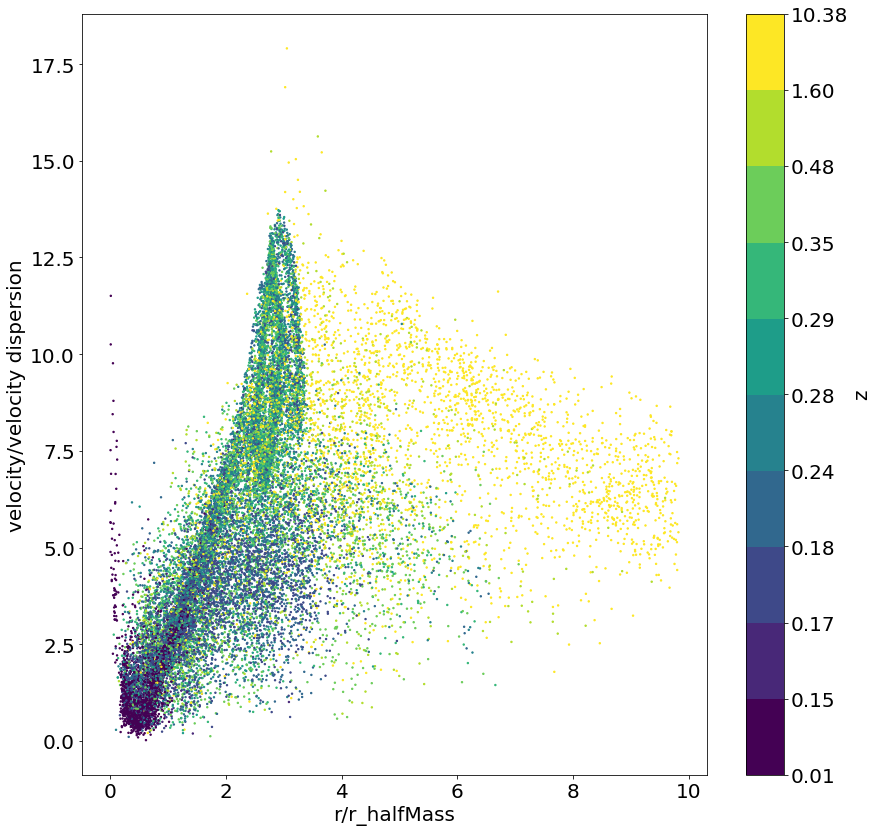

In [7]:
pl.figure(figsize=(14,14))
    
valranges = np.linspace(0, 100, 11)
vallims = np.percentile(valorder_near, valranges)
    
norm = mpc.BoundaryNorm(boundaries=vallims, ncolors=256)
    
pl.scatter(rhm, vdisp, marker='o', c=valorder_near, s=2, norm=norm)
    
pl.xlabel('r/r_halfMass')
pl.ylabel('velocity/velocity dispersion')
    
    
bar = pl.colorbar()
    
bar.set_ticks(vallims)
bar.set_label('z')
#bar.set_label('Internal Energy [km²/s²]')
#bar.set_label('Temperature/K')

In [ ]:
# a list of all satellites of 4337 and 4469, then all

allgroup = sim['SnapNumber_127/SubGroups/GroupNumber'][()]
group1 = sim['SnapNumber_127/SubGroups/GroupNumber'][4337]

ii = np.where(allgroup==group1)[0]
ii1 = list(ii[1:]) # the first one is the BGG
cen1 = [4337]*len(ii1)

group2 = sim['SnapNumber_127/SubGroups/GroupNumber'][4469]

ii_ = np.where(allgroup==group2)[0]
ii2 = list(ii_[1:])
cen2 = [4469]*len(ii2)

ii1.extend(ii2)
cen1.extend(cen2)

sats, cent = np.array(ii1), np.array(cen1)

In [ ]:
Rhm, Vvdist, Cvalue = [], [], []

bar = progressbar.ProgressBar(max_value=sats.size)
n = 0

for sa, ce in zip(sats, cent):
    rhm, vdisp, valorder_near = plotPhaseSpace(sa,ce)
    if sa==4470:
        print(rhm.size, vdisp.size, valorder_near.size)
    Rhm.extend(list(rhm))
    Vvdist.extend(list(vdisp))
    Cvalue.extend(list(valorder_near))
    n += 1
    bar.update(n)
    
Rhm, Vvdist, Cvalue = np.array(Rhm), np.array(Vvdist), np.array(Cvalue)

In [ ]:
pl.figure(figsize=(14,14))
    
valranges = np.linspace(0, 100, 11)
vallims = np.percentile(Cvalue, valranges)
    
norm = mpc.BoundaryNorm(boundaries=vallims, ncolors=256)
    
pl.scatter(Rhm, Vvdist, marker='o', c=Cvalue, s=2, norm=norm)
    
pl.xlabel('r/r_halfMass')
pl.ylabel('velocity/velocity dispersion')

bar = pl.colorbar()
    
bar.set_ticks(vallims)
#bar.set_label('z')
#bar.set_label('Internal Energy [km²/s²]')
bar.set_label('Temperature/K')

In [ ]:
pl.figure(figsize=(16, 16))

pl.hexbin(Rhm, Vvdist, C=Cvalue, gridsize=50, norm=norm)

pl.xlabel('r/r_halfMass')
pl.ylabel('velocity/velocity dispersion')

bar = pl.colorbar()
    
bar.set_ticks(vallims)
#bar.set_label('z')
#bar.set_label('Internal Energy [km²/s²]')
bar.set_label('Temperature/K')

In [ ]:
pl.figure(figsize=(16, 16))

pl.hexbin(Rhm, Vvdist, gridsize=50)

pl.xlabel('r/r_halfMass')
pl.ylabel('velocity/velocity dispersion')

bar = pl.colorbar()
    
#bar.set_ticks(vallims)
#bar.set_label('z')
bar.set_label('Number of gas particles')

In [8]:
Slist = h5py.File('SatelliteList_V2.h5', 'r')
Satellites = Slist['SatelliteList'][()]
Centrals = Slist['SatelliteCentral'][()]

In [9]:
Rhm2, Vvdist2, Cvalue2 = [], [], []

bar = progressbar.ProgressBar(max_value=Satellites.size)
n = 0

for sa2, ce2 in zip(Satellites, Centrals):
    rhm2, vdisp2, valorder_near2 = plotPhaseSpace(sa2,ce2)
    if sa2==4470:
        print(ce2, rhm2.size, vdisp2.size, valorder_near2.size)
    Rhm2.extend(list(rhm2))
    Vvdist2.extend(list(vdisp2))
    Cvalue2.extend(list(valorder_near2))
    n += 1
    bar.update(n)
    
Rhm2, Vvdist2, Cvalue2 = np.array(Rhm2), np.array(Vvdist2), np.array(Cvalue2)

 73% (745 of 1012) |###############      | Elapsed Time: 0:18:52 ETA:  14:36:59

4469 42105 42105 42105


 99% (1011 of 1012) |################### | Elapsed Time: 0:32:31 ETA:   0:00:00

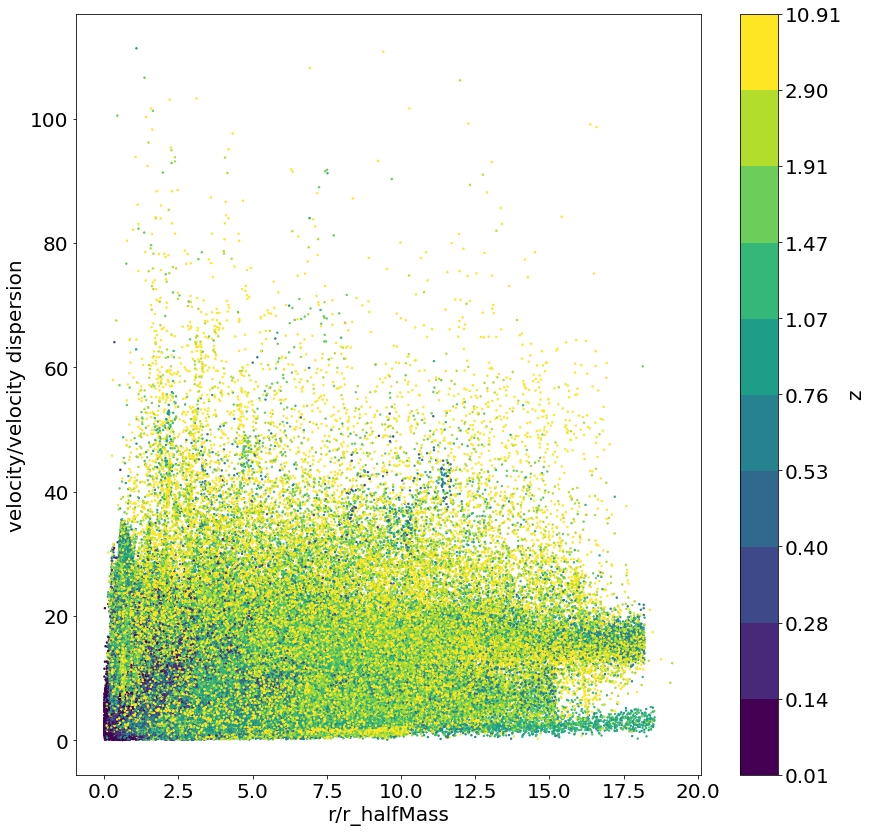

In [10]:
pl.figure(figsize=(14,14))
    
valranges = np.linspace(0, 100, 11)
vallims2 = np.percentile(Cvalue2, valranges)
    
norm2 = mpc.BoundaryNorm(boundaries=vallims2, ncolors=256)
    
pl.scatter(Rhm2, Vvdist2, marker='o', c=Cvalue2, s=2, norm=norm2)
    
pl.xlabel('r/r_halfMass')
pl.ylabel('velocity/velocity dispersion')

bar = pl.colorbar()
    
bar.set_ticks(vallims2)
bar.set_label('z')
#bar.set_label('Internal Energy [km²/s²]')
#bar.set_label('Temperature/K')

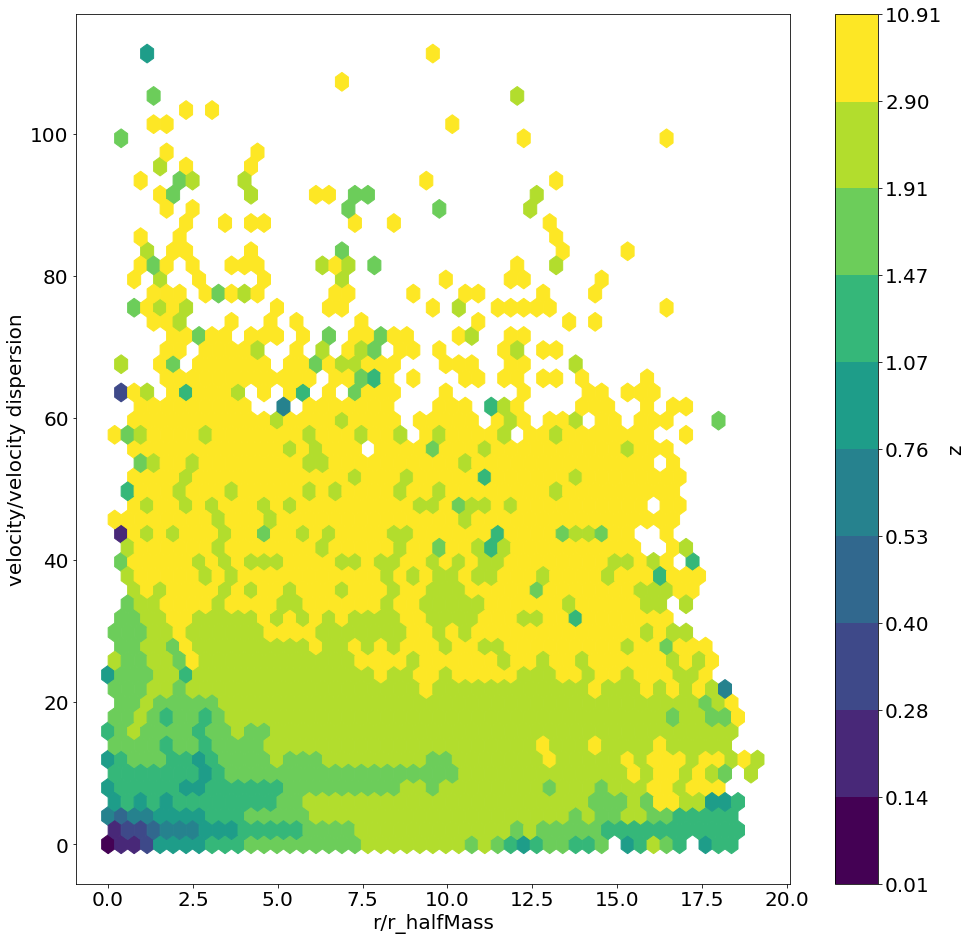

In [11]:
pl.figure(figsize=(16, 16))

pl.hexbin(Rhm2, Vvdist2, C=Cvalue2, gridsize=50, norm=norm2)

pl.xlabel('r/r_halfMass')
pl.ylabel('velocity/velocity dispersion')

bar = pl.colorbar()
    
bar.set_ticks(vallims2)
bar.set_label('z')
#bar.set_label('Internal Energy [km²/s²]')
#bar.set_label('Temperature/K')

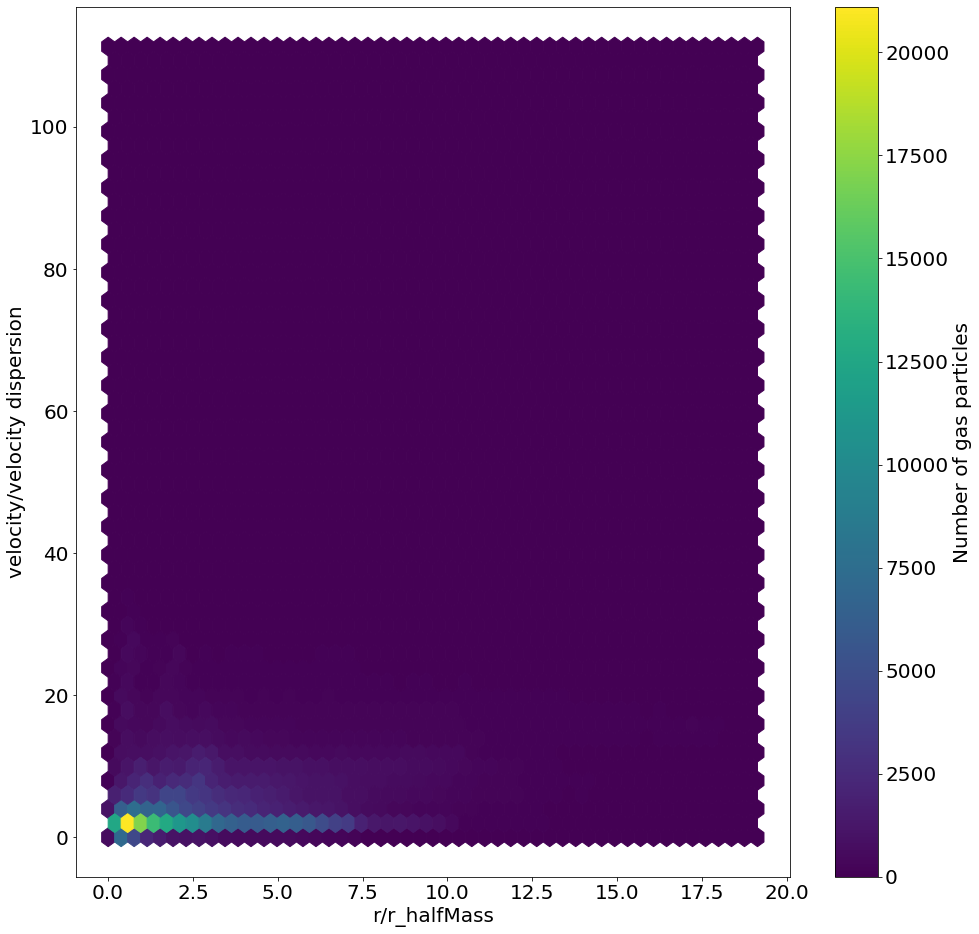

In [25]:
pl.figure(figsize=(16, 16))

pl.hexbin(Rhm2, Vvdist2, gridsize=50)

pl.xlabel('r/r_halfMass')
pl.ylabel('velocity/velocity dispersion')

bar = pl.colorbar()
    
#bar.set_ticks(vallims)
#bar.set_label('z')
bar.set_label('Number of gas particles')

In [ ]:
np.where(Satellites==4474)

In [10]:
Group = sim['SnapNumber_127/SubGroups/GroupNumber'][()]

In [11]:
sate, centr = [], []
gg = np.unique(Group)

In [12]:
gg.size

5021

In [13]:
for g in gg:
    ii = np.where(Group==g)[0]
    satt = ii[1:]
    centt = ii[0]
    sate.extend(list(satt))
    centr.extend([centt]*satt.size)

In [14]:
len(sate)

1012

In [17]:
sate, centr = np.array(sate), np.array(centr)

In [18]:
np.where(sate==4470)

(array([744]),)

In [19]:
centr[744]

4469

In [20]:
with h5py.File('SatelliteList_V2.h5', 'w') as f:
    f.create_dataset('SatelliteList', data=sate)
    f.create_dataset('SatelliteCentral', data=centr)